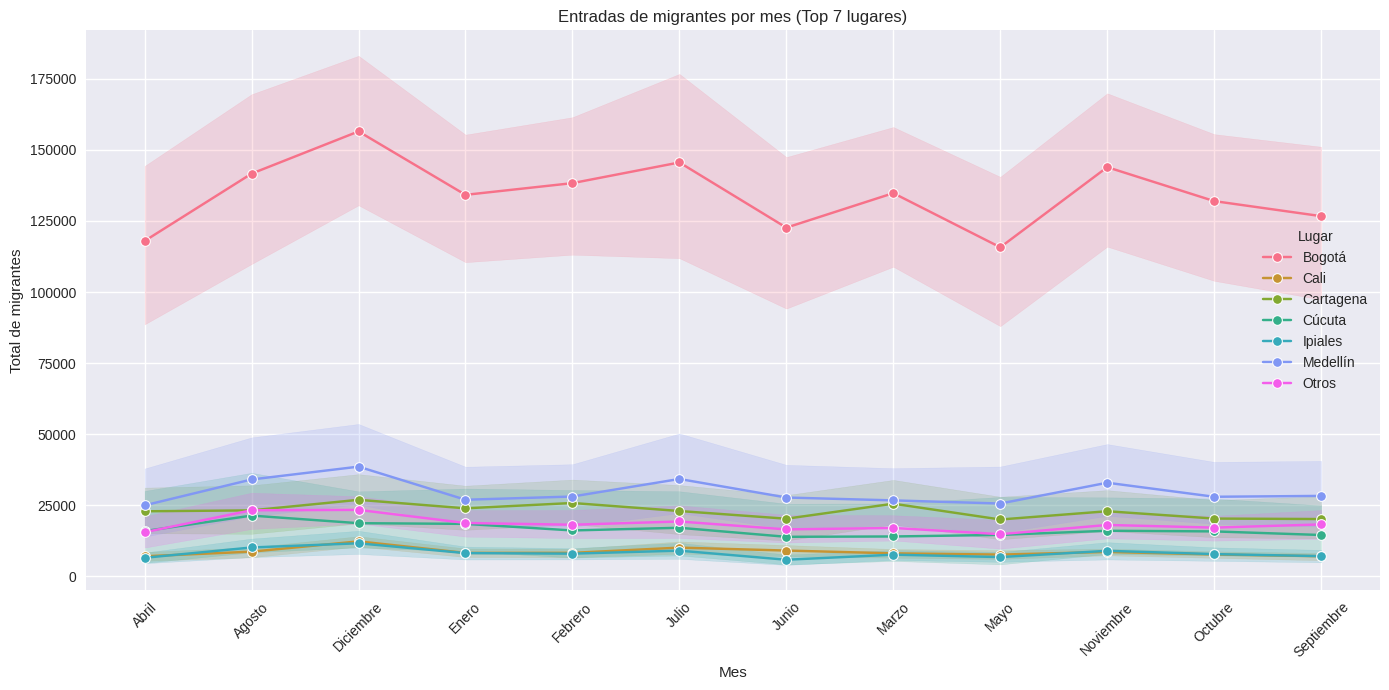

=== Estadísticas y Recomendaciones para los principales departamentos ===

Departamento: Bogotá
  - Promedio mensual de migrantes (bootstrap): 135535.4
  - Percentil 99 (máximo esperado): 229566.0
  - Probabilidad de superar el 80% de la capacidad: 99.1%
  - Probabilidad de sobrecupo (superar el 100%): 99.1%
  ⚠️ Recomendación: Alta probabilidad de sobrecupo. Refuerza urgentemente los servicios, deriva migrantes a otros departamentos o amplía la capacidad de atención.
------------------------------------------------------------
Departamento: Cali
  - Promedio mensual de migrantes (bootstrap): 8456.3
  - Percentil 99 (máximo esperado): 17587.0
  - Probabilidad de superar el 80% de la capacidad: 97.5%
  - Probabilidad de sobrecupo (superar el 100%): 96.9%
  ⚠️ Recomendación: Alta probabilidad de sobrecupo. Refuerza urgentemente los servicios, deriva migrantes a otros departamentos o amplía la capacidad de atención.
------------------------------------------------------------
Departamento

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Cargar el dataset
df = pd.read_csv("Entradas_de_extranjeros_a_Colombia_20250430.csv")

# 2. LIMPIEZA: Convertir 'Total' a numérico (elimina comas y convierte a float)
df['Total'] = df['Total'].astype(str).str.replace(',', '').astype(float)

# 3. Diccionario de coordenadas a nombre de lugar (añade más si lo necesitas)
coordenadas_a_lugar = {
    "(4.697144,-74.140516)": "Bogotá",
    "(6.171601,-75.427454)": "Medellín",
    "(7.818934,-72.453226)": "Cúcuta",
    "(8.364293,-72.405710)": "Arauca",
    "(10.408582,-75.538003)": "Cartagena",
    "(10.445761,-75.516429)": "Cartagena",
    "(0.814836,-77.662532)": "Ipiales",
    "(0.25129,-76.875963)": "Tumaco",
    "(-4.197703,-69.941278)": "Leticia",
    "(3.541112,-76.384584)": "Cali",
    "(8.635765,-77.346578)": "Turbo",
    # Añade más según tu dataset
}

def obtener_lugar(coord):
    coord = str(coord).replace(" ", "")
    return coordenadas_a_lugar.get(coord, "Otros")

df['Lugar'] = df['Latitud - Longitud'].apply(obtener_lugar)

# 4. Agrupar por año, mes y lugar
df_mes = df.groupby(['Año', 'Mes', 'Lugar'])['Total'].sum().reset_index()

# 5. Parámetros de la simulación
lugares = df_mes['Lugar'].unique()
n_bootstrap = 1000  # Número de remuestreos
capacidad_maxima = 1000  # Capacidad máxima de atención por mes por lugar
umbral_alerta = 0.8      # 80% de la capacidad

# 6. Simulación Bootstrap por lugar
resultados = []

for lugar in lugares:
    datos_hist = df_mes[df_mes['Lugar'] == lugar]['Total'].astype(float).values
    if len(datos_hist) < 5:
        continue
    # Asegúrate de que las simulaciones sean floats
    simulaciones = np.random.choice(datos_hist, size=n_bootstrap, replace=True).astype(float)
    alertas = np.sum(simulaciones > capacidad_maxima * umbral_alerta)
    criticos = np.sum(simulaciones > capacidad_maxima)
    resultados.append({
        'Lugar': lugar,
        'Promedio_migrantes': np.mean(simulaciones),
        'P99': np.percentile(simulaciones, 99),
        'Prob_alerta_80%': alertas / n_bootstrap,
        'Prob_critico_100%': criticos / n_bootstrap
    })

df_result = pd.DataFrame(resultados)

# 7. Filtrar los lugares principales
top_n = 7
top_lugares = df_result.sort_values('Promedio_migrantes', ascending=False).head(top_n)['Lugar']

# 8. Usar la gráfica original pero solo para los lugares principales
import seaborn as sns

df_mes_top = df_mes[df_mes['Lugar'].isin(top_lugares)]

plt.figure(figsize=(14,7))
sns.lineplot(data=df_mes_top, x='Mes', y='Total', hue='Lugar', marker='o')
plt.title('Entradas de migrantes por mes (Top 7 lugares)')
plt.ylabel('Total de migrantes')
plt.xticks(rotation=45)
plt.legend(title='Lugar')
plt.tight_layout()
plt.show()

# Selecciona solo los lugares de la gráfica (Top 7)
df_top = df_result[df_result['Lugar'].isin(top_lugares)]

print("=== Estadísticas y Recomendaciones para los principales departamentos ===\n")

for idx, row in df_top.iterrows():
    print(f"Departamento: {row['Lugar']}")
    print(f"  - Promedio mensual de migrantes (bootstrap): {row['Promedio_migrantes']:.1f}")
    print(f"  - Percentil 99 (máximo esperado): {row['P99']:.1f}")
    print(f"  - Probabilidad de superar el 80% de la capacidad: {row['Prob_alerta_80%']*100:.1f}%")
    print(f"  - Probabilidad de sobrecupo (superar el 100%): {row['Prob_critico_100%']*100:.1f}%")

    # Recomendaciones según el nivel de riesgo
    if row['Prob_critico_100%'] > 0.1:
        print("  ⚠️ Recomendación: Alta probabilidad de sobrecupo. Refuerza urgentemente los servicios, deriva migrantes a otros departamentos o amplía la capacidad de atención.")
    elif row['Prob_alerta_80%'] > 0.2:
        print("  🔶 Recomendación: Riesgo moderado de saturación. Monitorea de cerca, prepara contingencias y campañas de información.")
    else:
        print("  🟢 Recomendación: Riesgo bajo de saturación. Mantén el monitoreo regular.")
    print("-" * 60)